In [103]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml

import sys
sys.path.append('../cytof')

from hyperion_preprocess import cytof_read_data_roi
from hyperion_analysis import check_feature_distribution
from utils import save_multi_channel_img

In [104]:
class options:
    def __init__(self):
        self.filename = "../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt"
        self.outdir  = "../test_out/single_roi"
        self.slide   = "NP37646_B5"
        self.roi     = "ROI_001B_9"
        self.quality_control_thres = 50
        
        self.channel_dict = {
            'nuclei': ['191Ir(Ir191Di)', '193Ir(Ir193Di)', 'Histone3(Yb176Di)'],
            'membrane': []
        }
        self.keep_origs      = True
        self.channels_remove = []
        self.use_membrane    = True
        self.cell_radius     = 5
        self.normalize_qs    = [75, 99]

params = options()

In [105]:
outdir = os.path.join(params.outdir, params.slide, params.roi)

In [106]:
from classes import CytofCohort

f_cohort1 = "test_cohort.csv"

cytof_cohort = CytofCohort(file_cohort=os.path.join(outdir, f_cohort1), 
            file_io=os.path.join(outdir,'input_output.csv'), 
            dir_out=outdir)

In [107]:
# import pandas as pd
# list(pd.read_csv(os.path.join(outdir,'input_output.csv'))['output_file'])[0]#.split('/')[-1].split('.pkl')[0]

'../test_out/single_roi/NP37646_B5/ROI_001B_9/cytof_img.pkl'

In [114]:
# cytof_cohort.get_images()
get_images(cytof_cohort)

In [115]:
import copy

def scale_feature(self):
    """Scale features for all normalization q values"""
    cytof_img = list(self.cytof_imgs.values())[0]
    # features to be scaled
    s_features = [col for key, features in cytof_img.features.items() \
                          for f in features \
                          for col in cytof_img.df_feature.columns if col.startswith(f)]
    
    for normq in self.normqs:
        n_attr = f"df_feature_{normq}normed"
        n_attr_scaled = f"df_feature_{normq}normed_scaled"

        if not hasattr(self, n_attr):
            self.get_feature(normq=normq, feat_type="normed")

        df_feature = getattr(self, n_attr)

        # calculate scaling parameters
        df_scale_params = df_feature[s_features].mean().to_frame(name="mean").transpose()
        df_scale_params = pd.concat([df_scale_params, df_feature[s_features].std().to_frame(name="std").transpose()])
        
        # 
        m = df_scale_params[df_scale_params.columns].iloc[0] # mean
        s = df_scale_params[df_scale_params.columns].iloc[1] # std.dev
        
        df_feature_scale = copy.deepcopy(getattr(cytof_img, n_attr))
        
        assert len([x for x in df_scale_params.columns if x not in df_scale_params.columns]) == 0

        # scale
        df_feature_scale[df_scale_params.columns] = (df_feature_scale[df_scale_params.columns] - m) / s
        setattr(self, n_attr_scaled, df_feature_scale)
    return df_scale_params

df_scale_params = scale_feature(cytof_cohort)
# savename_cytof_img = os.path.join(outdir, "cytof_img.pkl")
# cytof_img.save_cytof(savename_cytof_img)
# df_scale_params

In [116]:
key_pheno = cytof_cohort.clustering_phenograph(normq=99, feat_type="normed_scaled", 
                                               feat_set="all", pheno_markers="all",
                                               k=None, save_vis=True)


The attribute name of the feature: df_feature_99normed_scaled
Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3471081256866455 seconds
Jaccard graph constructed in 5.04386830329895 seconds
Wrote graph to binary file in 0.14453935623168945 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.619771
After 3 runs, maximum modularity is Q = 0.625831
After 4 runs, maximum modularity is Q = 0.629128
Louvain completed 24 runs in 10.36488151550293 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 20.96497130393982 seconds

10 communities found. The dictionary key for phenograph: 99normed_scaled_all_50_all.


In [78]:
cytof_cohort.df_cohort["Slide"].unique()

array(['NP37646_B5'], dtype=object)

In [85]:
df_slide_roi    = cytof_cohort.df_cohort
pheno_out       = cytof_cohort.phenograph[key_pheno]
df_feat_all     = getattr(cytof_cohort, pheno_out['feat_attr']) # original feature (to use the slide/ roi /filename info) data
df_pheno_all    = pheno_out['data'] # phenograph data
proj_2d_all     = pheno_out['proj_2d']
communities_all = pheno_out['communities']  

df_feature_roi, proj_2d_roi, communities_roi = {}, {}, {}        
for i in df_slide_roi.index:
    path_i = df_slide_roi.loc[i, "path"]
    roi_i  = df_slide_roi.loc[i, "ROI"]
    f_in   = os.path.join(path_i, roi_i)
    cond   = df_feat_all["filename"] == f_in
    df_feature_roi[roi_i.replace(".txt", "")] = df_pheno_all.loc[cond, :] 
    proj_2d_roi[roi_i.replace(".txt", "")] = proj_2d_all[cond, :] 
    communities_roi[roi_i.replace(".txt", "")] = communities_all[cond] 

In [99]:
pheno_out['feat_attr']

'df_feature_99normed_scaled'

In [98]:
list(df_feat_all["filename"])

['../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/cohort1/NP37646_B5/TM14MAR20_NP37646_B5_ROI_001B_9.txt',
 '../../image_cytof_test_data/hyperion/c

In [88]:
for i in df_slide_roi.index:
    print(i)

0


../cytof/utils.py:122: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=data[:,0], y=data[:,1], hue=communities, palette='tab20',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Visualization in 2d - slide-NP37646_B5
saving plot to ../test_out/single_roi/NP37646_B5/ROI_001B_9/phenograph/99normed_scaled_all_50_all-10/cluster_scatter_slide_NP37646_B5.png


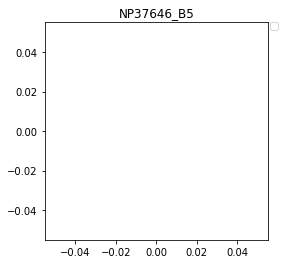

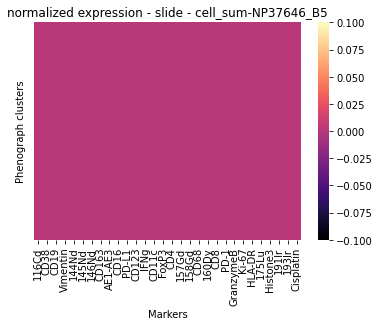

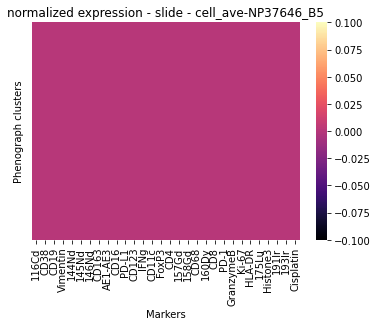

In [81]:
df_feats, commus, cluster_protein_exps = cytof_cohort.vis_phenograph(key_pheno, level="slide", 
                                                                     accumul_type=None, save_vis=True)

# df_feats_, commus_, cluster_protein_exps_ = cytof_cohort.vis_phenograph(key_pheno, level="slide", 
#                                                            accumul_type=None, save_vis=True,
#                                                            normalize=True
#                                                           )